## NetLogo interaction through the pyNetLogo connector: sensitivity analysis with SALib

This notebook provides a more advanced example of interaction between NetLogo and a Python environment, using the SALib library (Herman & Usher, 2017; available through the pip package manager) to sample and analyze a suitable experimental design for a Sobol global sensitivity analysis.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jpype
import pyNetLogo

#Import the sampling and analysis modules for a Sobol variance-based sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

SALib relies on a problem definition dictionary which contains the number of input parameters to sample, their names (which should here correspond to a NetLogo global variable), and the sampling bounds. 

In [3]:
problem = { 
  'num_vars': 6,
  'names': ['random-seed',
            'grass-regrowth-time',
            'sheep-gain-from-food',
            'wolf-gain-from-food',
            'sheep-reproduce',
            'wolf-reproduce'], 
  'bounds': [[1, 100000],
             [20., 40.], 
             [2., 8.], 
             [16., 32.],
             [2., 8.],
             [2., 8.]]
}

We start by instantiating the wolf-sheep predation example model, specifying the _gui=False_ flag to run in headless mode.

In [4]:
netlogo = pyNetLogo.NetLogoLink(gui=False)
netlogo.load_model(r'Wolf Sheep Predation_v6.nlogo')

The SALib sampler will automatically generate an appropriate number of samples for Sobol analysis. To calculate first-order and total sensitivity indices, this gives a sample size of _n*(p+2)_, where _p_ is the number of input parameters, and _n_ is a baseline sample size which should be large enough to stabilize the estimation of the indices. For this example, we use _n_ = 200 to reduce runtime, for a total of 1600 experiments.

For more complex cases, the EMA Workbench library (Kwakkel, 2017) can be used to parallelize the simulation.

In [5]:
n = 200
#Generates an input array of shape (n*(p+2), p) with rows for each experiment and columns for each input parameter
param_values = saltelli.sample(problem, n, calc_second_order=False)

print param_values.shape

(1600L, 6L)


Assuming we are interested in the mean number of sheep and wolf agents over a timeframe of 100 ticks, we first create an empty dataframe to store the results.

In [6]:
results = pd.DataFrame(columns=['Avg. sheep', 'Avg. wolves'])

We then simulate the model over the 1600 experiments, reading input parameters from the param_values array generated by SALib. 

For simplicity, the repeat_report command is used to track the outcomes of interest over time. Performance can be improved by using NetLogo's text output commands to store time series outcomes; this method is also implemented in the EMA Workbench. 

In [7]:
for run in range(param_values.shape[0]):
    
    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(param_values[run,i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, param_values[run,i]))
            
    netlogo.command('setup')
    #Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(['count sheep','count wolves'], 100)
    
    #For each run, save the mean value of the agent counts over time
    results.loc[run, 'Avg. sheep'] = counts['count sheep'].values.mean()
    results.loc[run, 'Avg. wolves'] = counts['count wolves'].values.mean()

The "to_pickle" dataframe method provides a simple way of saving the results to disk.

In [ ]:
results.to_pickle('Sobol_JASSS.pk')

We can then proceed with the analysis, first using a histogram to visualize output distributions for each outcome:

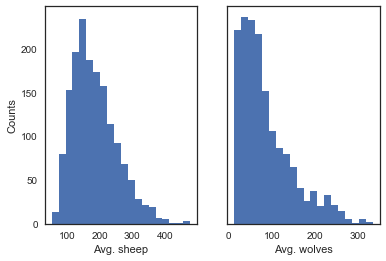

In [64]:
sns.set_style('white')
fig, ax = plt.subplots(1,len(results.columns), sharey=True)

for i, n in enumerate(results.columns):
    ax[i].hist(results[n], 20)
    ax[i].set_xlabel(n)

ax[0].set_ylabel('Counts')
plt.show()

Bivariate scatter plots can be useful to visualize relationships between each input parameter and the outputs. Taking the outcome for the average sheep count as an example, we obtain the following, using the scipy library to calculate the Pearson correlation coefficient (r) for each parameter:

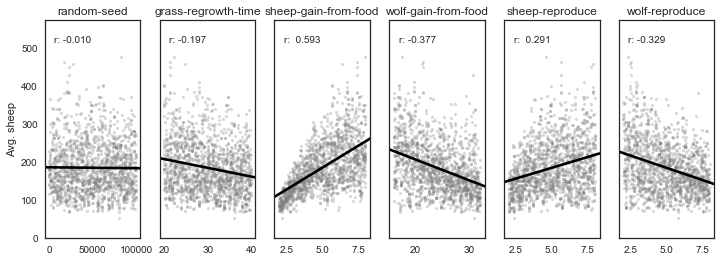

In [74]:
import scipy

fig, ax = plt.subplots(1, len(problem['names']), sharey=True)

y = results['Avg. sheep']

for i, name in enumerate(problem['names']):
    x = param_values[:,i]
    sns.regplot(x, y, ax=ax[i], ci=None, color='k',scatter_kws={'alpha':0.3, 's':10, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    ax[i].annotate("r: {:6.3f}".format(pearson[0]), xy=(0.1, 0.9), xycoords='axes fraction')
    if i>0:
        ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(name)
ax[0].set_ylim([0,1.2*np.max(y)])
ax[0].set_ylabel('Avg. sheep')

fig.set_size_inches(12,4,forward=True) 
fig.subplots_adjust(hspace=0.15, wspace=0.2)
plt.show()

This indicates a positive relationship between the "sheep-gain-from-food" parameter and the mean sheep count, and negative relationships for the "wolf-gain-from-food" and "wolf-reproduce" parameters.

We can then use SALib to calculate first-order (S1) and total (ST) Sobol indices, to estimate each input's contribution to output variance. By default, 95% confidence intervals are estimated for each index (S1_conf and ST_conf).

In [38]:
Si = sobol.analyze(problem, results['Avg. sheep'].values, calc_second_order=False, print_to_console=False)
Si_df = pd.DataFrame(Si, index=problem['names'])

In [51]:
Si_df

,S1,S1_conf,ST,ST_conf
random-seed,0.149951,0.134383,0.061332,0.020702
grass-regrowth-time,0.073008,0.156248,0.112861,0.034606
sheep-gain-from-food,0.279258,0.378098,0.536844,0.152346
wolf-gain-from-food,0.277912,0.298716,0.267168,0.095189
sheep-reproduce,0.121080,0.292459,0.267704,0.108091
wolf-reproduce,0.233518,0.273144,0.214715,0.067502


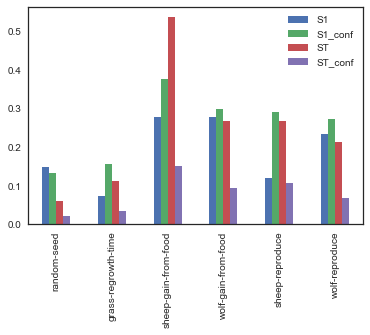

In [60]:
Si_df.plot(kind='bar')
plt.show()

The "sheep-gain-from-food" parameter has the highest ST index, indicating that it contributes over 50% of output variance when accounting for interactions with other parameters. However, it can be noted that the confidence bounds are overly broad due to the small _n_ value used for sampling, so that a larger sample would be required for reliable results. For instance, the S1 index is estimated to be larger than ST for the "random-seed" parameter, which is an artifact of the small sample size.

Finally, the kill_workspace() function shuts down the NetLogo instance.

In [25]:
netlogo.kill_workspace()